In [1]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

In [2]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01 
epochs=20
device = 'cuda'
train_batch_size = 64
test_batch_size = 64

### DATASET CLASS

In [52]:
from dataset import ImageWoof
from matplotlib import pyplot as plt

from torchinfo import summary


In [53]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, 7, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(8, 16, 5, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #####
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(
                output_size=8,
            ),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, start_dim=1)
        out = self.classifier(features)
        return out

    def num_of_params(self):
        total = 0
        for layer_params in self.feature_extractor.parameters():
            total += layer_params.numel()
        for layer_params in self.classifier.parameters():
            total += layer_params.numel()
        return total

### INITIALISE THE DATASET and THE DATALOADERS 

In [54]:

START_seed()
# Define your transformations
train_transform = transforms.Compose([transforms.Resize((160,160)),  transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #add your augmentations
test_transform = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Train dataset
train_dataset =  ImageWoof(
    root=".", train=True, transform=train_transform, img_size=160
)

test_dataset = ImageWoof(
    root=".", train=False, transform=test_transform, img_size=160
)

## split into train, val, test 
print(len(train_dataset))     
val_size = int(0.1 * len(train_dataset))
print(val_size)
train_size = len(train_dataset) - val_size
train, val = torch.utils.data.random_split(train_dataset, [train_size, val_size])  

train_loader = torch.utils.data.DataLoader(
    train, batch_size=train_batch_size, shuffle=True, num_workers=8
)
val_loader = torch.utils.data.DataLoader(
    val, batch_size=train_batch_size, shuffle=False, num_workers=1
)    
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_batch_size, shuffle=False, num_workers=1
)

9025
902


## Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


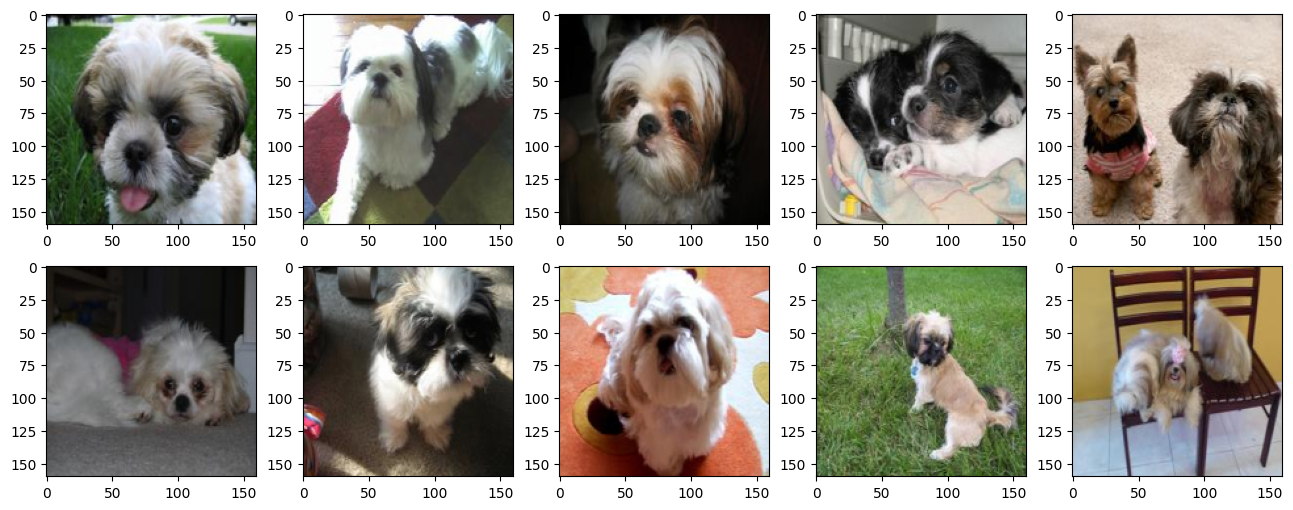

In [55]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

### Training and evaluation loop

In [56]:
# ## Creating training loop
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct=0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            tepoch.set_postfix(loss=loss.item())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))

In [57]:
best_accuracy = 0.0
def validate(model):
    global best_accuracy
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        if (100.*correct/total) > best_accuracy:
            print("Saving the best model...")
            best_accuracy = (100.*correct/total)
            torch.save(model.state_dict(), 'best_model.pth')
        print(' val loss: {:.4f} accuracy: {:.4f} best_accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total, best_accuracy))


### Initialise the model, optimizers, schedulers 

In [58]:
START_seed()
import torchvision.models as models

# model = models.vgg16(pretrained=False)
# model.classifier[-1].out_features = 6
# model.head = nn.Linear(model.head.in_features, 6)

model = CNN(num_classes=10)

print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): AdaptiveAvgPool2d(output_size=8)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) 


In [60]:
model.to(device)
start = time.time()

for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train( model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


  0%|          | 0/127 [00:00<?, ?batch/s]

100%|██████████| 127/127 [00:14<00:00,  8.94batch/s, loss=2.31]


 train loss: 147.3837 accuracy: 10.2918


100%|██████████| 15/15 [00:01<00:00,  8.55batch/s]


Saving the best model...
 val loss: 2.3087 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 1


100%|██████████| 127/127 [00:14<00:00,  8.87batch/s, loss=2.3] 


 train loss: 147.3661 accuracy: 10.2918


100%|██████████| 15/15 [00:01<00:00,  8.89batch/s]


 val loss: 2.3084 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 2


100%|██████████| 127/127 [00:14<00:00,  8.90batch/s, loss=2.31]


 train loss: 147.3491 accuracy: 10.2918


100%|██████████| 15/15 [00:01<00:00,  8.63batch/s]


 val loss: 2.3081 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 3


100%|██████████| 127/127 [00:14<00:00,  8.87batch/s, loss=2.31]


 train loss: 147.3326 accuracy: 10.2918


100%|██████████| 15/15 [00:01<00:00,  8.90batch/s]


 val loss: 2.3078 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 4


100%|██████████| 127/127 [00:13<00:00,  9.22batch/s, loss=2.31]


 train loss: 147.3167 accuracy: 10.2918


100%|██████████| 15/15 [00:01<00:00,  8.60batch/s]


 val loss: 2.3076 accuracy: 9.4235 best_accuracy: 9.4235
epoch number: 5


 96%|█████████▌| 122/127 [00:14<00:00,  8.71batch/s, loss=2.29]


KeyboardInterrupt: 

### Test the model 

In [27]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

# Usage example:

# Assuming you have a model, test_loader, and best_model_path defined

best_model_path = 'best_model.pth'  # Replace with the actual path and filename of the best model

test_best_model(model, test_loader, nn.CrossEntropyLoss(), best_model_path)


100%|████████████████████████████████████████| 24/24 [00:12<00:00,  1.89batch/s]

Test loss: 2.0488 Accuracy: 17.50%
